# Manipulating Eta in LKJCholeskyCov

So far, the effect of the eta $\eta$ parameter in `LKJCholeskyCov` has been opaque to me (see here:
https://discourse.pymc.io/t/correlated-slopes-in-multivariate-model/1485 and 
https://discourse.pymc.io/t/weird-posterior-for-correlation-structure-using-lkj-distribution/1639/2
). 

I was never sure what values to set and which effect they have. 
Also, in my complex data set, even extreme values seemed to have no effect.

Thus, here is a reduced example.
We simulate five observed variables `A`-`E` ("parameters").

- `A` is unaltered and independent of others.
- `B` and `C` are affected by a `condition`.
- `D` and `E` are correlated.
- `F` and `G` are correlated and affected by the `condition`.

Let's see if (and with which `eta` values) the model can recover this structure, using `MvNormal` with `LKJCholeskyCov`.

In [1]:
import sys as SYS
import numpy as NP
import numpy.random as RND
import pandas as PD
import scipy.stats as STATS

import pymc3 as PM
import theano as TH
import theano.tensor as TT
import patsy as PA

import matplotlib as MP
import matplotlib.pyplot as MPP


%matplotlib inline
PD.set_option('precision', 4)

RND.seed(123)


# ignore pymc/theano FutureWarnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

# Generate Data

In [2]:

# data specifications
n_observations = 100

conditions = [0,1]
n_conditions = len(conditions)

parameters = ['A','B','C','D','E','F','G'] 
n_parameters = len(parameters)

# arbitrary start values
actual_components = {  'A':  0.1 \
                     , 'B':  0.6, 'C':  0.6 # affected by condition \
                     , 'D':  0.3, 'E': -0.5 # correlated \
                     , 'F':  0.3, 'G': -0.5 # both \
                    }

# additional effects of the condition
actual_effect = {'B': -0.1, 'C':  0.2, 'F': -0.1, 'G':  0.2}
noise = 0.05

# data frame with actual parameter values per condition
actual_parameters = PD.concat([PD.DataFrame(actual_components, index = [cond]) for cond in conditions])
for idx, effect in actual_effect.items():
    actual_parameters.loc[1, idx] += effect

# simulated observations
data = PD.DataFrame.from_dict({'condition': RND.choice(conditions, n_observations)})
block = actual_parameters.loc[data['condition'].values, :]
block.loc[:,:] += RND.normal(0, noise, block.shape)
for col in parameters:
    data[col] = block[col].values

# add correlation
for parameter_pair in [['D','E'], ['F','G']]:
    correlation = RND.normal(0, 0.2, n_observations)
    data[parameter_pair[0]] += correlation
    data[parameter_pair[1]] += correlation
actual_correlations = [STATS.pearsonr(data['D'].values, data['E'].values)[0] \
                       , STATS.pearsonr(data['F'].values, data['G'].values)[0]]
print ('correlation:', *NP.round(actual_correlations,2))
actual_correlations = actual_correlations + [0]*(((n_parameters**2-n_parameters)//2)-2) # for later plotting

# show data
data.head(6)

correlation: 0.95 0.71


/usr/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


condition       A       B       C       D       E       F       G
0          0  0.1489  0.7119  0.5353  0.1016 -0.5593  0.1217 -0.6369
1          1  0.1535  0.5445  0.8877  0.6261 -0.1952  0.1884 -0.2333
2          0  0.1157  0.5337  0.6709  0.5667 -0.2714  0.8417 -0.0066
3          0  0.1100  0.6234  0.5584  0.2474 -0.6655  0.1831 -0.4587
4          0  0.0798  0.5937  0.5581  0.5245 -0.1325  0.1788 -0.5038
5          0  0.1404  0.5843  0.5457  0.1267 -0.6973  0.0708 -0.8253

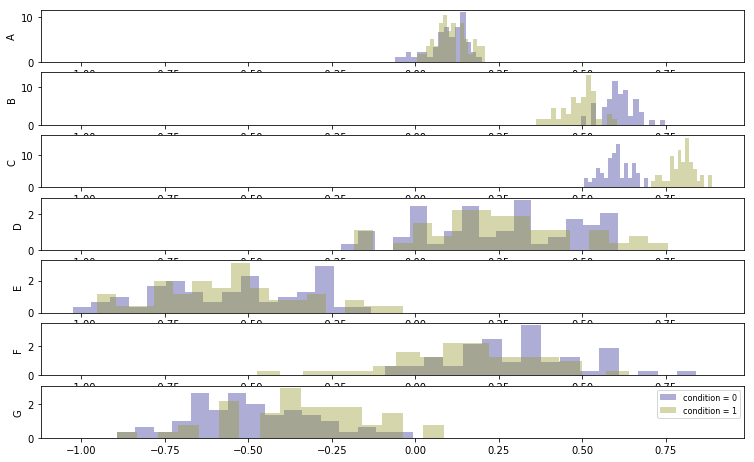

In [15]:
fig = MPP.figure(figsize = [32/2.54,20/2.54])

colors = {0: (0.2, 0.2, 0.6), 1: (0.6, 0.6, 0.2)}

ref_ax = None
for row, param in enumerate(parameters):
    if ref_ax is None:
        ax = fig.add_subplot(n_parameters, 1, row+1 )
        ref_ax = ax
    else: 
        ax = fig.add_subplot(n_parameters, 1, row+1, sharex = ref_ax )
        
    for cond in conditions:
        ax.hist(   data.loc[data['condition'].values == cond, [param]].values \
                 , bins = 16 \
                 , color = colors[cond] \
                 , density = True, histtype = 'stepfilled', alpha = 0.4, label = 'condition = %i' %(cond))

    ax.set_ylabel(param)
    
ax.legend(loc = 'best', fontsize = 8)
MPP.show()

# Model Generation

In [4]:
conditions_index = NP.array(data['condition'].values, dtype = int)

mu_0 = 0* data.loc[:, parameters].mean()
sigma_0 = 1+0* data.loc[:, parameters].std()

def CreateModel(eta = 1.):
    with PM.Model() as model:
        estimator = 0

        ### intercept
        intercept_dmatrix = NP.asarray( \
                              PA.dmatrix( "1" \
                            , data = data \
                            , return_type = 'dataframe' \
                            ))
        intercept = PM.Normal('intercept', mu_0, sigma_0 \
                             , shape = (1,n_parameters))
        estimator += TT.dot(intercept_dmatrix, intercept) 

        ### slope
        slope_dmatrix = NP.asarray(PA.dmatrix( "0 + condition" \
                            , data = data \
                            , return_type = 'dataframe' \
                            ))
        slope = PM.Normal('slope', NP.zeros(n_parameters), sigma_0 \
                             , shape = (1,n_parameters))

        estimator += TT.dot(slope_dmatrix, slope) 


        ### observations
        sd_dist = PM.HalfNormal.dist(2.)
        packed_cholesky = PM.LKJCholeskyCov(  'packed_cholesky' \
                                            , n = n_parameters \
                                            , eta = eta \
                                            , sd_dist = sd_dist \
                                            )

        # compute the observables covariance and correlation matrix 
        cholesky_matrix = PM.expand_packed_triangular(n_parameters, packed_cholesky, lower = True)
        covariance_matrix = PM.Deterministic('covariance_matrix' \
                                             , TT.dot(cholesky_matrix, cholesky_matrix.T) \
                                            )
        standard_deviations = PM.Deterministic('standard_deviations' \
                                             , TT.sqrt(TT.diag(covariance_matrix)) \
                                            )
        correlation_matrix = PM.Deterministic('correlation_matrix' \
                                            , TT.diag(standard_deviations**-1) \
                                                .dot(covariance_matrix.dot(TT.diag(standard_deviations**-1))) \
                                            )
        cross_correlation = PM.Deterministic('cross_correlation' \
                                             , correlation_matrix[NP.triu_indices(n_parameters, k=1)] \
                                            )

        ## observations
        observables = PM.MvNormal( 'observables' \
                                , mu = estimator \
                                , chol = cholesky_matrix \
                                , observed = data.loc[:, parameters].values \
                                )
    model.name = "eta=%.0e" % (eta)
    return model

## (I) Low Eta

In [5]:
model_loweta = CreateModel(eta = 10**-4)

with model_loweta:
    trace_loweta = PM.sample(draws = 2**10, tune = 2**10, cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_cholesky, slope, intercept]
Sampling 2 chains: 100%|██████████| 4096/4096 [00:49<00:00, 83.21draws/s] 


/usr/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


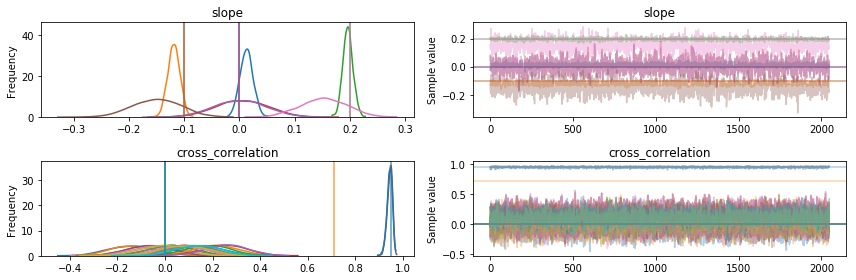

In [16]:
PM.traceplot(trace_loweta, combined = True, varnames = ['slope', 'cross_correlation'] \
            , lines = {'slope': [actual_effect.get(param, 0) for param in parameters] \
                      , 'cross_correlation': actual_correlations \
                      } \
            )
MPP.show()

The model with low eta:

- captures the isolated `condition` effects
- and also the correlation
- but **misses** correlation in the combined case, although low eta should favor correlation[1].


[1] see https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.LKJCholeskyCov

## (II) Eta 1 Uniform

In [7]:
model_oneeta = CreateModel(eta = 10**0)

with model_oneeta:
    trace_oneeta = PM.sample(draws = 2**10, tune = 2**10, cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_cholesky, slope, intercept]
Sampling 2 chains: 100%|██████████| 4096/4096 [00:45<00:00, 89.71draws/s] 


/usr/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


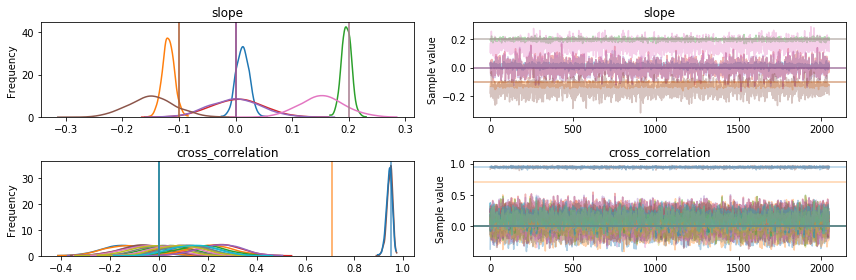

In [17]:
PM.traceplot(trace_oneeta, combined = True, varnames = ['slope', 'cross_correlation'] \
            , lines = {'slope': [actual_effect.get(param, 0) for param in parameters] \
                      , 'cross_correlation': actual_correlations \
                      } \
            )
MPP.show()

The model with `eta = 1` gives accurate slope and correlation.

## (III) High Eta

In [9]:
model_higheta = CreateModel(eta = 10**4)

with model_higheta:
    trace_higheta = PM.sample(draws = 2**10, tune = 2**10, cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_cholesky, slope, intercept]
Sampling 2 chains: 100%|██████████| 4096/4096 [00:38<00:00, 185.34draws/s]


/usr/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


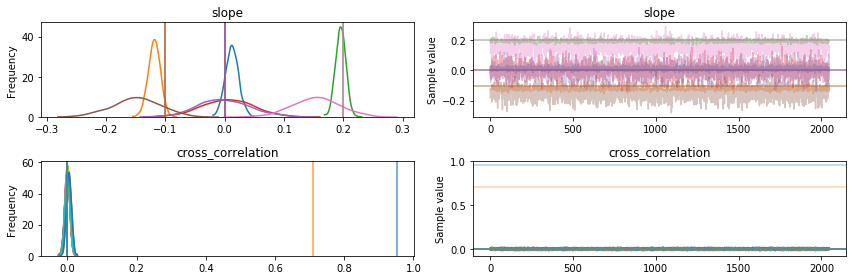

In [18]:
PM.traceplot(trace_higheta, combined = True, varnames = ['slope', 'cross_correlation'] \
            , lines = {'slope': [actual_effect.get(param, 0) for param in parameters] \
                      , 'cross_correlation': actual_correlations \
                      } \
            )
MPP.show()

The model with low eta:

- retrieves the `condition` slopes
- **misses** all correlation.

# Free $\eta$!


Finally, let's leave eta free and check if it can be retrieved by inference.

In [11]:
with PM.Model() as model_freeeta:
    estimator = 0

    ### intercept
    intercept_dmatrix = NP.asarray( \
                          PA.dmatrix( "1" \
                        , data = data \
                        , return_type = 'dataframe' \
                        ))
    intercept = PM.Normal('intercept', mu_0, sigma_0 \
                         , shape = (1,n_parameters))
    estimator += TT.dot(intercept_dmatrix, intercept) 

    ### slope
    slope_dmatrix = NP.asarray(PA.dmatrix( "0 + condition" \
                        , data = data \
                        , return_type = 'dataframe' \
                        ))
    slope = PM.Normal('slope', NP.zeros(n_parameters), sigma_0 \
                         , shape = (1,n_parameters))

    estimator += TT.dot(slope_dmatrix, slope) 


    ### observations
    sd_dist = PM.HalfNormal.dist(2.)
    eta = PM.Exponential('eta', 1.)
    packed_cholesky = PM.LKJCholeskyCov(  'packed_cholesky' \
                                        , n = n_parameters \
                                        , eta = eta \
                                        , sd_dist = sd_dist \
                                        )

    # compute the observables covariance and correlation matrix 
    cholesky_matrix = PM.expand_packed_triangular(n_parameters, packed_cholesky, lower = True)
    covariance_matrix = PM.Deterministic('covariance_matrix' \
                                         , TT.dot(cholesky_matrix, cholesky_matrix.T) \
                                        )
    standard_deviations = PM.Deterministic('standard_deviations' \
                                         , TT.sqrt(TT.diag(covariance_matrix)) \
                                        )
    correlation_matrix = PM.Deterministic('correlation_matrix' \
                                        , TT.diag(standard_deviations**-1) \
                                            .dot(covariance_matrix.dot(TT.diag(standard_deviations**-1))) \
                                        )
    cross_correlation = PM.Deterministic('cross_correlation' \
                                         , correlation_matrix[NP.triu_indices(n_parameters, k=1)] \
                                        )

    ## observations
    observables = PM.MvNormal( 'observables' \
                            , mu = estimator \
                            , chol = cholesky_matrix \
                            , observed = data.loc[:, parameters].values \
                            )
model_freeeta.name = "free eta"

In [12]:
with model_freeeta:
    trace_freeeta = PM.sample(draws = 2**10, tune = 2**10, cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_cholesky, eta, slope, intercept]
Sampling 2 chains: 100%|██████████| 4096/4096 [00:49<00:00, 55.76draws/s] 
There were 739 divergences after tuning. Increase `target_accept` or reparameterize.
There were 718 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/usr/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


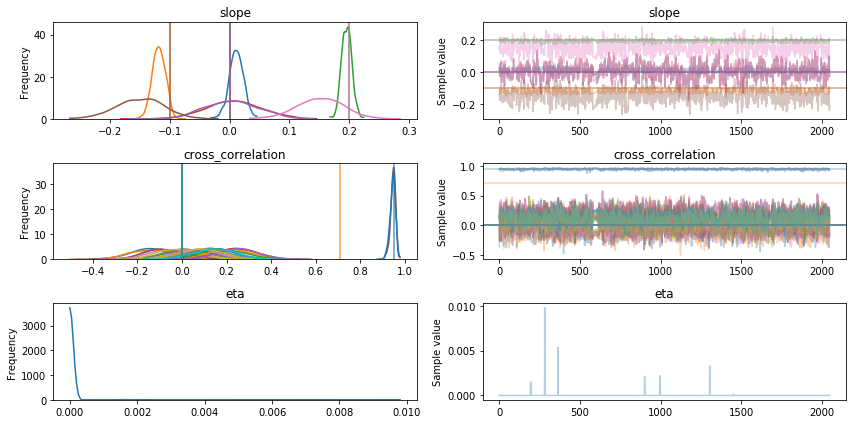

In [19]:
PM.traceplot(trace_freeeta, combined = True, varnames = ['slope', 'cross_correlation', 'eta'] \
            , lines = {'slope': [actual_effect.get(param, 0) for param in parameters] \
                      , 'cross_correlation': actual_correlations \
                      } \
            )
MPP.show()

Again, something close to zero, but note the sampling issues.

# Model Comparison

/usr/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


           WAIC  pWAIC  dWAIC weight     SE    dSE var_warn
eta=1e+00 -1505  37.64      0      1  34.49      0        1
eta=1e-04 -1504  38.35   1.03      0   34.6   0.72        1
free eta  -1504  38.17   1.34      0  34.39   0.76        1
eta=1e+04 -1045  19.86  460.7      0  44.13  26.57        1


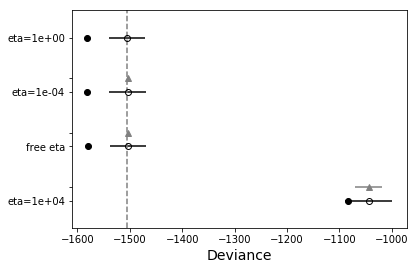

In [20]:
comp_waic = PM.compare({ \
                          model_loweta: trace_loweta \
                        , model_oneeta: trace_oneeta \
                        , model_higheta: trace_higheta \
                        , model_freeeta: trace_freeeta \
                    })
print (comp_waic)
PM.compareplot(comp_waic)
MPP.show()

The inaccuracy of the "high eta" model is reflected in model comparison.

# Summary

- Indeed, condition effect and correlation are hard to separate in this simple case.
- Choosing eta among the lower values seems voodoo.
- Even leaving eta free does not improve the result, and it seems to be challenging for the sampler. 
- Instead of setting high eta, one could use an uncorrelated estimate.


I will leave eta at one for my models, unless there is good reason to deviate from that.